Load Train, Val, and Test Datasets into Memory

In [48]:
import pickle
import os
import sys

# Manually add the project root to sys.path
sys.path.append('/Users/joaquinuriarte/Documents/GitHub/sports-betting/')

# File path to processed_dataset
processed_dataset_path = "/Users/joaquinuriarte/Documents/GitHub/sports-betting/processed_datasets/model_v0/processed_dataset.pkl"

with open(processed_dataset_path, "rb") as f:
    processed_dataset = pickle.load(f)
    print("processed_dataset leaded to memory")

final_features = processed_dataset.features

processed_dataset leaded to memory


In [58]:
team_a_features = final_features.filter(like='A_player').groupby(lambda x: x.split('_', 3)[-1], axis=1).mean()
team_b_features = final_features.filter(like='B_player').groupby(lambda x: x.split('_', 3)[-1], axis=1).mean()
team_a_features.describe()
team_b_features.describe()
team_a_features.info()
team_b_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25445 entries, 11400001 to 52100211
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AST         25445 non-null  float64
 1   DREB        25445 non-null  float64
 2   FG3_PCT     25445 non-null  float64
 3   FG_PCT      25445 non-null  float64
 4   FT_PCT      25445 non-null  float64
 5   MIN         25445 non-null  float64
 6   OREB        25445 non-null  float64
 7   PF          25445 non-null  float64
 8   PLUS_MINUS  25445 non-null  float64
 9   PTS         25445 non-null  float64
 10  TO          25445 non-null  float64
dtypes: float64(11)
memory usage: 2.3 MB


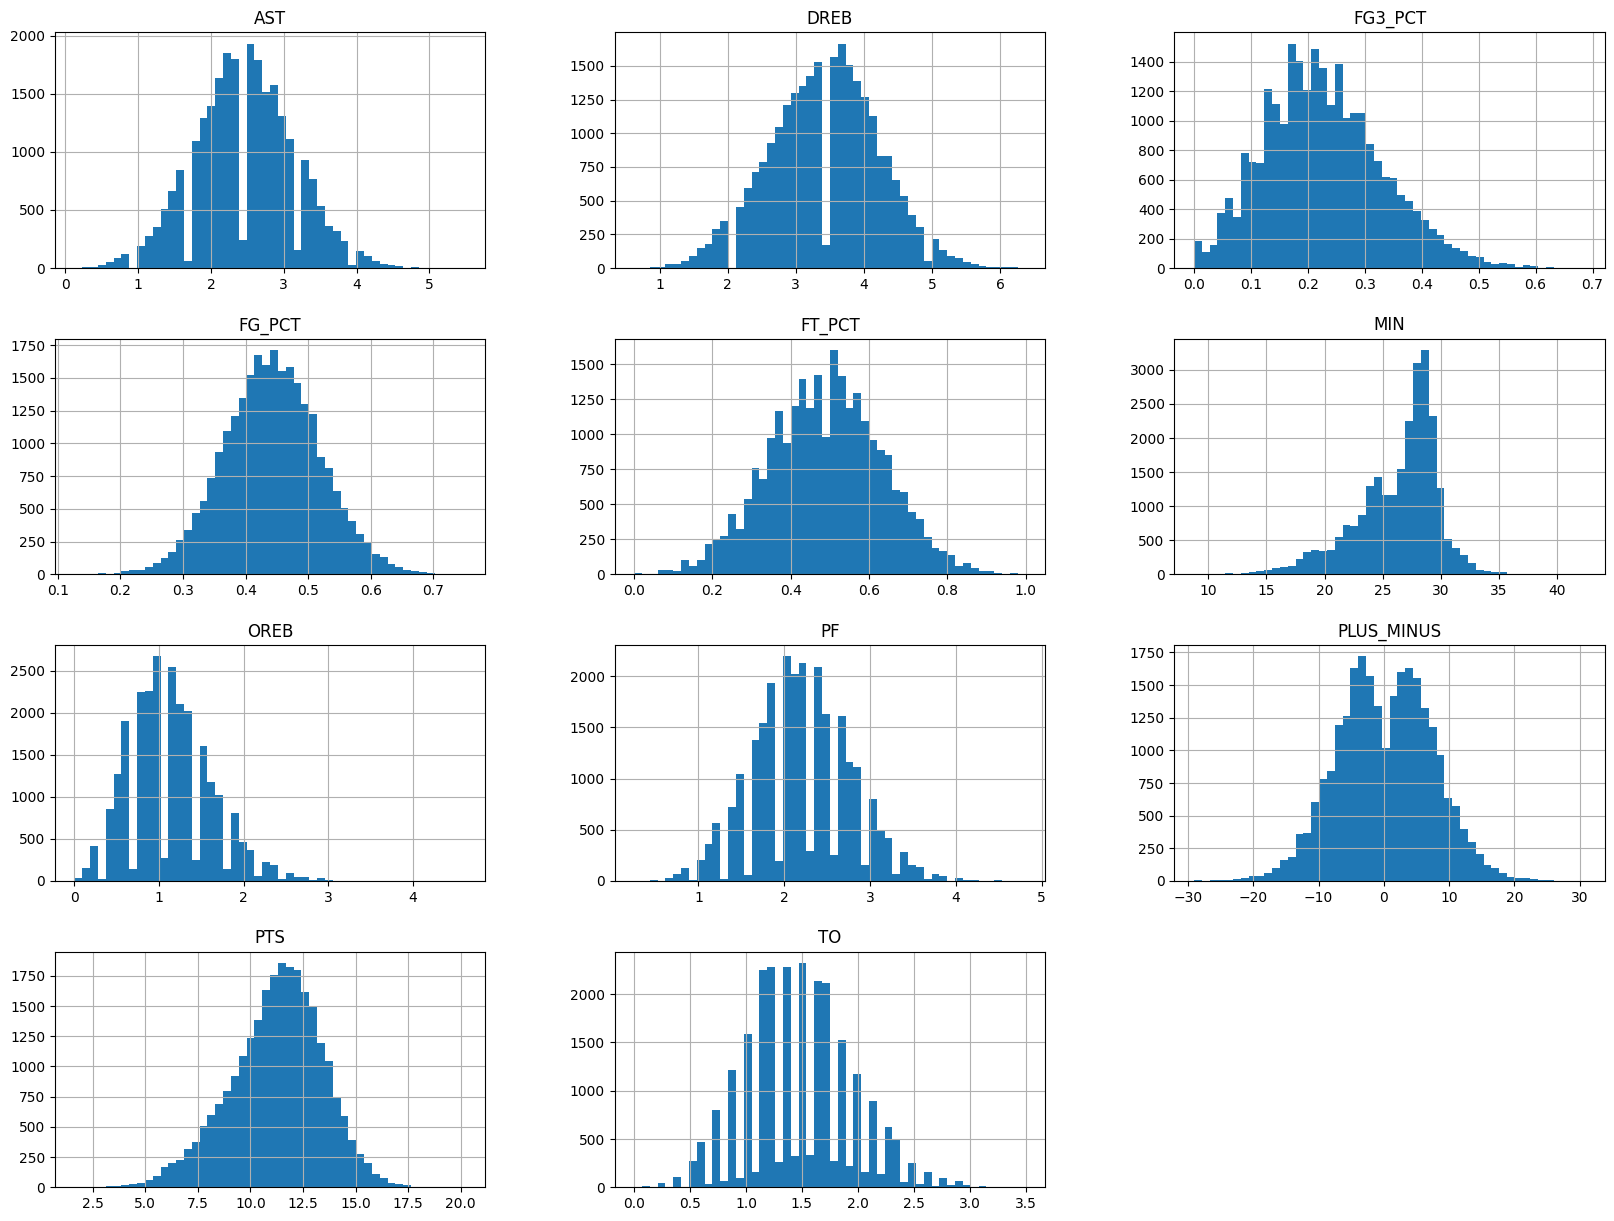

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
team_a_features.hist(bins=50, figsize=(20,15))
plt.show()

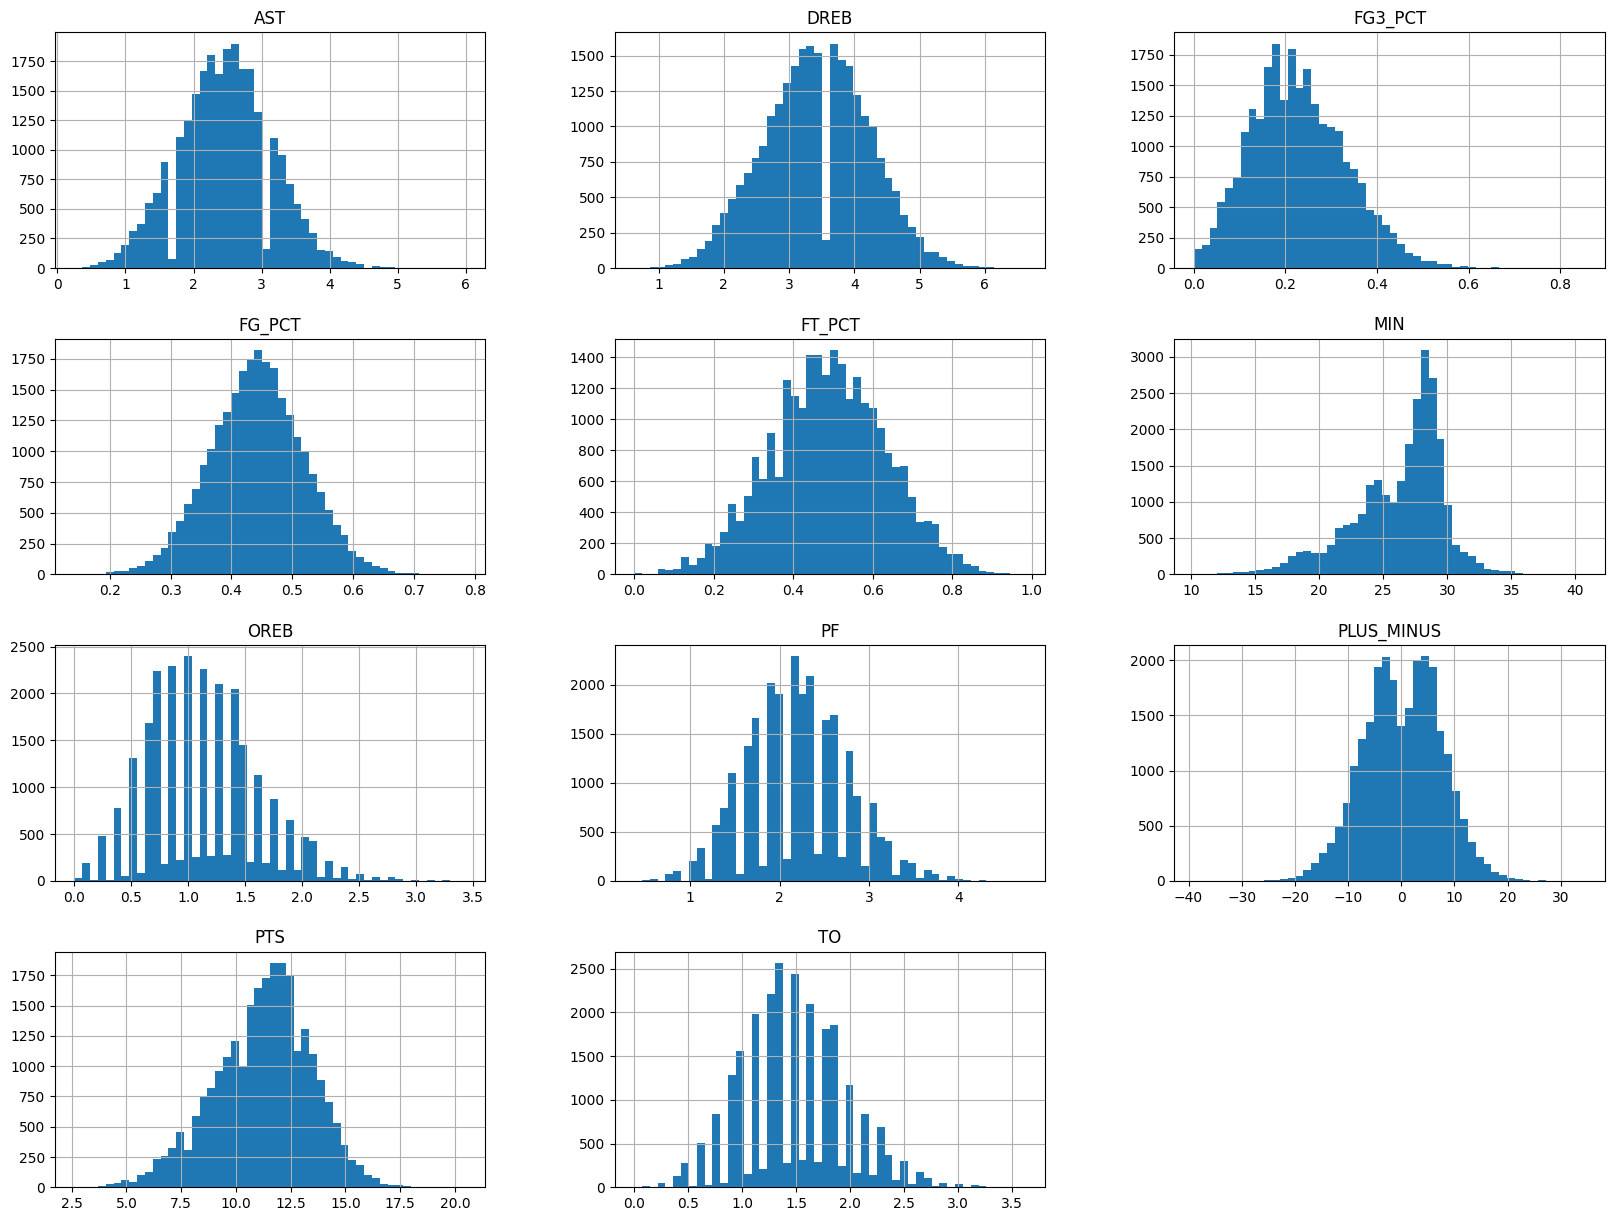

In [60]:
team_b_features.hist(bins=50, figsize=(20,15))
plt.show()

Deprecated (Except Correlation Analysis)

In [19]:
assert all(
    col.startswith(("A_", "B_")) or col == "Team_A_Wins"
    for col in final_features.columns
), "Unexpected columns found in the dataset."
assert final_features["Team_A_Wins"].dtype == "int", "Team_A_Wins must be integer."

assert not final_features.isna().any().any(), "Dataset contains missing values."

In [20]:
assert (
    abs(final_features.filter(like="A_").mean().mean() - final_features.filter(like="B_").mean().mean())
    < .0449
), "Team A and Team B feature distributions are significantly different."
min_columns = [col for col in final_features.columns if col.endswith("_MIN")]
assert final_features[min_columns].min().min() >= 0, "Negative MIN values detected."

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, skew, chi2_contingency
from typing import Dict, Any

def explore_features(dataframe: pd.DataFrame):
    """
    Analyze each feature in the DataFrame and print out its traits.

    For this EDA, averages the features for Team A and Team B to reduce the number of features.

    Args:
        dataframe (pd.DataFrame): Input DataFrame with player-level features.

    Returns:
        Dict: A dictionary containing analysis results for each feature.
    """
    # Aggregate player-level features into team-level averages
    team_a_features = dataframe.filter(like='A_player').groupby(lambda x: x.split('_', 3)[-1], axis=1).mean()
    team_b_features = dataframe.filter(like='B_player').groupby(lambda x: x.split('_', 3)[-1], axis=1).mean()

    # Combine aggregated features with the label
    aggregated_dataframe = pd.concat([
        team_a_features.add_prefix('A_'),
        team_b_features.add_prefix('B_'),
        dataframe[['Team_A_Wins']]
    ], axis=1)

    feature_analysis = {}

    for column in aggregated_dataframe.columns:
        if column == 'Team_A_Wins':
            continue

        print(f"\nAnalyzing feature: {column}")
        feature_data = aggregated_dataframe[column]

        # Initialize results for this feature
        analysis = {}

        # Identify the type
        if feature_data.dtypes == 'object':
            unique_values = feature_data.nunique()
            if unique_values < 0.1 * len(feature_data):
                feature_type = "Categorical"
            else:
                feature_type = "Text"
        elif np.issubdtype(feature_data.dtypes, np.number):
            feature_type = "Numerical"
        else:
            feature_type = "Structured"

        analysis['type'] = feature_type

        # Percentage of values equal to 0
        zero_percentage = (feature_data == 0).mean() * 100
        analysis['zero_percentage'] = zero_percentage

        # Noisiness and type of noise
        if feature_type == "Numerical":
            # Outliers using IQR
            q1, q3 = np.percentile(feature_data.dropna(), [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outlier_percentage = ((feature_data < lower_bound) | (feature_data > upper_bound)).mean() * 100
            analysis['outliers_percentage'] = outlier_percentage
            analysis['noise_type'] = "Outliers" if outlier_percentage > 2 else "Minimal"

        # Distribution type
        if feature_type == "Numerical":
            skewness = skew(feature_data.dropna())
            analysis['skewness'] = skewness

            # normaltest test for normality
            p_value = normaltest(feature_data.dropna())[1]
            if p_value > 0.05:
                distribution_type = "Gaussian"
            else:
                distribution_type = "Non-Gaussian"

            analysis['distribution_type'] = distribution_type

        # Graph the attribute
        plt.figure(figsize=(8, 4))
        if feature_type == "Numerical":
            sns.histplot(feature_data, kde=True, bins=30, color='blue')
            plt.title(f"Distribution of {column}")
        elif feature_type == "Categorical":
            sns.countplot(x=feature_data, palette='viridis')
            plt.title(f"Value Counts for {column}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Correlation metric
        if feature_type == "Numerical":
            correlation_with_others = aggregated_dataframe.corrwith(feature_data)
            analysis['correlation_with_others'] = correlation_with_others.sort_values(ascending=False).to_dict()
        elif feature_type == "Categorical":
            # Cramér's V for categorical correlation
            def cramers_v(x, y):
                contingency_table = pd.crosstab(x, y)
                chi2 = chi2_contingency(contingency_table)[0]
                n = contingency_table.sum().sum()
                return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

            categorical_cols = aggregated_dataframe.select_dtypes(include=['object']).columns
            cramer_v_scores = {}
            for cat_col in categorical_cols:
                if cat_col != column:
                    cramer_v_scores[cat_col] = cramers_v(feature_data, aggregated_dataframe[cat_col])
            analysis['correlation_with_others'] = cramer_v_scores

        feature_analysis[column] = analysis

        # Print analysis
        for key, value in analysis.items():
            if isinstance(value, dict):
                print(f"  {key}: {{...}} (dictionary of length {len(value)})")
            else:
                print(f"  {key}: {value}")

    return feature_analysis

In [ ]:
feature_analysis = explore_features(final_features)

Correlation Analysis

In [24]:
print("Correlation analysis: printing feature pairs with more than 0.8 correlation coefficient.")
# Use a set of frozensets to store symmetric pairs without duplication
correlations = set()

for columns in feature_analysis.keys():
    for correlation in feature_analysis[columns]["correlation_with_others"].keys():
        if feature_analysis[columns]["correlation_with_others"][correlation] >= 0.8 and columns != correlation:
            # Add the pair as a frozenset (unordered, avoids duplicates)
            correlations.add(frozenset([columns, correlation]))
        

for pair in correlations:
    print(pair)

print("Complete")

Correlation analysis: printing feature pairs with more than 0.8 correlation coefficient.
Complete
